## Prac1. Basic CNN Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
## GPU/CPU Setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


In [3]:
## import dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform = transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform = transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 100

train_loader = DataLoader(dataset= train_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset= test_dataset, batch_size= batch_size, shuffle=False)

torch.Size([100])
torch.Size([100, 3, 32, 32])
torch.Size([3, 32, 32])
tensor(9)


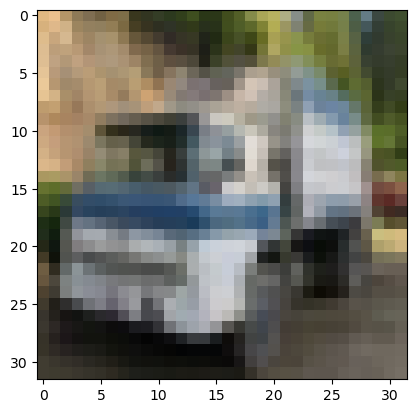

In [5]:
# print dataset form and image

for i, data in enumerate(train_loader):
    x, y = data
    print(y.shape)
    print(x.shape) # batch_size, channel, width, height
    print(x[0].shape)
    print(y[0])
    plt.imshow(x[0].permute(1, 2, 0))
    break

In [6]:
## Convolutional layers
conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=1)
conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=0)
print(conv1)
print(conv2)

input_data = torch.Tensor(1, 3, 32, 32)
print(input_data.shape)

print(conv1(input_data).shape)

pool = nn.MaxPool2d(2)
print(pool(conv1(input_data)).shape)

final_output = conv2(pool(conv1(input_data)))
print(final_output.shape)

final_output = pool(final_output)
print(final_output.shape)

out = final_output.view(final_output.shape[0], -1)
print(out.shape)

fc = nn.Linear(1152, 10)
fc(out).shape

Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
torch.Size([1, 3, 32, 32])
torch.Size([1, 64, 34, 34])
torch.Size([1, 64, 17, 17])
torch.Size([1, 128, 7, 7])
torch.Size([1, 128, 3, 3])
torch.Size([1, 1152])


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 10])

In [7]:
## Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=1, stride=1, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=0),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        
        self.fc = nn.Linear(3*3*128, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        
        return out

In [8]:
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)

In [9]:
## Hyperparameters
num_epochs = 10
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
## Model Train

loss_list = []

for epoch_num in range(num_epochs):
    average_cost = 0
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        x_data = x_data.to(device)
        input_image = x_data.reshape(batch_size, 3, 32, 32)
        label = y_label.to(device)
        
        optimizer.zero_grad()
        
        y_predict = model(input_image)
        loss = criterion(y_predict, label)
        
        loss.backward()
        optimizer.step()
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss)
        
    print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 1.56840
Epoch 2 Loss 1.17599
Epoch 3 Loss 1.07852
Epoch 4 Loss 1.01596
Epoch 5 Loss 0.96814
Epoch 6 Loss 0.93106
Epoch 7 Loss 0.89896
Epoch 8 Loss 0.86813
Epoch 9 Loss 0.84103
Epoch 10 Loss 0.81512


In [11]:
## validation

with torch.no_grad():
    num_total_data = 0
    correct = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.reshape(batch_size, 3, 32, 32)
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        outputs_softmax = F.softmax(outputs, dim=1)
        
        predicted = torch.argmax(outputs_softmax, dim=1)
        
        num_total_data += len(images)
        
        answer = sum(label == predicted).item()
        correct += answer
        
print("Model accuracy {:.5f}%".format((correct / num_total_data) * 100))

Model accuracy 9.36000%


## Prac2. ResNet Fine-tuning

In [12]:
## model 불러오기 (학습된 weight까지 불러오겠다.)
model = torchvision.models.resnet18(pretrained=True)
model

/Users/jeongmingyeong/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jeongmingyeong/anaconda3/envs/ML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# model을 우리 task에 맞게 재정의
# model.fc의 in_feature는 그대로 사용하고
# out_feature를 1000개가 아닌 10개로 출력해주는 모델로 정의

model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
## Model Train
## 변경한 구조의 weight 재학습

loss_list = []

for epoch_num in range(num_epochs):
    average_cost = 0
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        x_data = x_data.to(device)
        input_image = x_data.reshape(batch_size, 3, 32, 32)
        label = y_label.to(device)
        
        optimizer.zero_grad()
        
        y_predict = model(input_image)
        loss = criterion(y_predict, label)
        
        loss.backward()
        optimizer.step()
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss)
        
    print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

KeyboardInterrupt: 

In [ ]:
## validation

with torch.no_grad():
    num_total_data = 0
    correct = 0
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.reshape(batch_size, 3, 32, 32)
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        outputs_softmax = F.softmax(outputs, dim=1)
        
        predicted = torch.argmax(outputs_softmax, dim=1)
        
        num_total_data += len(images)
        
        answer = sum(label == predicted).item()
        correct += answer
        
print("Model accuracy {:.5f}".format((correct / num_total_data) * 100))